In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/liver-cirrhosis-stage-classification/liver_cirrhosis.csv


<h2>Begining</h2>

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [12]:
df = pd.read_csv('/kaggle/input/liver-cirrhosis-stage-classification/liver_cirrhosis.csv')

In [13]:
df.head()

N_Days Status     Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
0    2221      C  Placebo  18499   F       N            Y       N     N   
1    1230      C  Placebo  19724   M       Y            N       Y     N   
2    4184      C  Placebo  11839   F       N            N       N     N   
3    2090      D  Placebo  16467   F       N            N       N     N   
4    2105      D  Placebo  21699   F       N            Y       N     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0        0.5        149.0     4.04   227.0     598.0   52.70           57.0   
1        0.5        219.0     3.93    22.0     663.0   45.00           75.0   
2        0.5        320.0     3.54    51.0    1243.0  122.45           80.0   
3        0.7        255.0     3.74    23.0    1024.0   77.50           58.0   
4        1.9        486.0     3.54    74.0    1052.0  108.50          109.0   

   Platelets  Prothrombin  Stage  
0      256.0          9.9      1  
1      220.0         10.8      2  
2      225.0         10.0      2  
3      151.0         10.2      2  
4      151.0         11.5      1

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  object 
 2   Drug           25000 non-null  object 
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  object 
 5   Ascites        25000 non-null  object 
 6   Hepatomegaly   25000 non-null  object 
 7   Spiders        25000 non-null  object 
 8   Edema          25000 non-null  object 
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    25000 non-null  float64
 18  Stage 

In [15]:
df.describe()

N_Days           Age     Bilirubin   Cholesterol       Albumin  \
count  25000.000000  25000.000000  25000.000000  25000.000000  25000.000000   
mean    1887.117040  18495.877080      3.402644    372.331471      3.486578   
std     1091.690918   3737.596616      4.707491    193.668452      0.380488   
min       41.000000   9598.000000      0.300000    120.000000      1.960000   
25%     1080.000000  15694.000000      0.800000    275.000000      3.290000   
50%     1680.000000  18499.000000      1.300000    369.510563      3.510000   
75%     2576.000000  20955.000000      3.400000    369.510563      3.750000   
max     4795.000000  28650.000000     28.000000   1775.000000      4.640000   

             Copper      Alk_Phos          SGOT  Tryglicerides     Platelets  \
count  25000.000000  25000.000000  25000.000000   25000.000000  25000.000000   
mean     100.184663   1995.675597    123.166345     123.822548    256.007337   
std       73.184840   1798.885660     47.747616      52.786350     98.679006   
min        4.000000    289.000000     26.350000      33.000000     62.000000   
25%       52.000000   1032.000000     92.000000      92.000000    189.000000   
50%       97.648387   1828.000000    122.556346     124.702128    251.000000   
75%      107.000000   1982.655769    134.850000     127.000000    311.000000   
max      588.000000  13862.400000    457.250000     598.000000    721.000000   

        Prothrombin        Stage  
count  25000.000000  25000.00000  
mean      10.734549      2.00116  
std        0.904436      0.81387  
min        9.000000      1.00000  
25%       10.000000      1.00000  
50%       10.600000      2.00000  
75%       11.100000      3.00000  
max       18.000000      3.00000

In [16]:
df['Sex'] = df['Sex'].map({'F': 0, 'M': 1})
df['Status'] = df['Status'].map({'C': 0, 'CL': 1, 'D': 2})
df['Drug'] = df['Drug'].map({'Placebo': 0, 'D-penicillamine': 1})
yes_no = {'N': 0, 'Y': 1}
df = df.replace({'Ascites': yes_no, 'Hepatomegaly': yes_no, 'Spiders': yes_no})
df['Edema'] = df['Edema'].map({'N': 0, 'S': 1, 'Y': 2})

/tmp/ipykernel_33/2723973965.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'Ascites': yes_no, 'Hepatomegaly': yes_no, 'Spiders': yes_no})


In [17]:
df.head()

N_Days  Status  Drug    Age  Sex  Ascites  Hepatomegaly  Spiders  Edema  \
0    2221       0     0  18499    0        0             1        0      0   
1    1230       0     0  19724    1        1             0        1      0   
2    4184       0     0  11839    0        0             0        0      0   
3    2090       2     0  16467    0        0             0        0      0   
4    2105       2     0  21699    0        0             1        0      0   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0        0.5        149.0     4.04   227.0     598.0   52.70           57.0   
1        0.5        219.0     3.93    22.0     663.0   45.00           75.0   
2        0.5        320.0     3.54    51.0    1243.0  122.45           80.0   
3        0.7        255.0     3.74    23.0    1024.0   77.50           58.0   
4        1.9        486.0     3.54    74.0    1052.0  108.50          109.0   

   Platelets  Prothrombin  Stage  
0      256.0          9.9      1  
1      220.0         10.8      2  
2      225.0         10.0      2  
3      151.0         10.2      2  
4      151.0         11.5      1

In [18]:
df.isnull().count()

N_Days           25000
Status           25000
Drug             25000
Age              25000
Sex              25000
Ascites          25000
Hepatomegaly     25000
Spiders          25000
Edema            25000
Bilirubin        25000
Cholesterol      25000
Albumin          25000
Copper           25000
Alk_Phos         25000
SGOT             25000
Tryglicerides    25000
Platelets        25000
Prothrombin      25000
Stage            25000
dtype: int64

<Axes: >

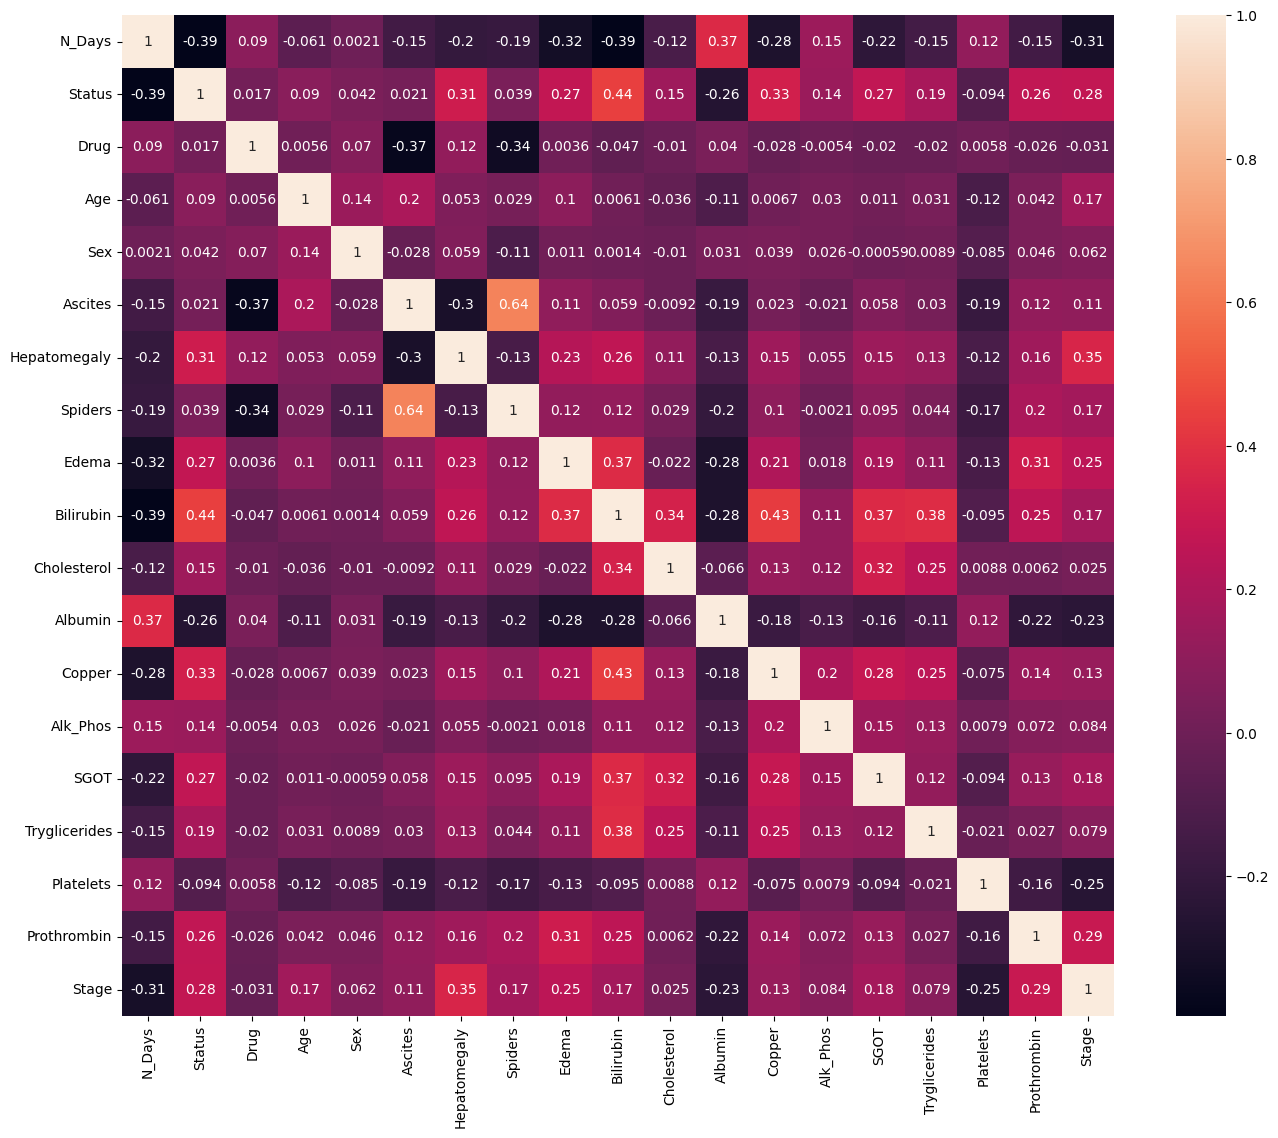

In [19]:
plt.subplots(figsize=(16,13))
sns.heatmap(df.corr(), annot = True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

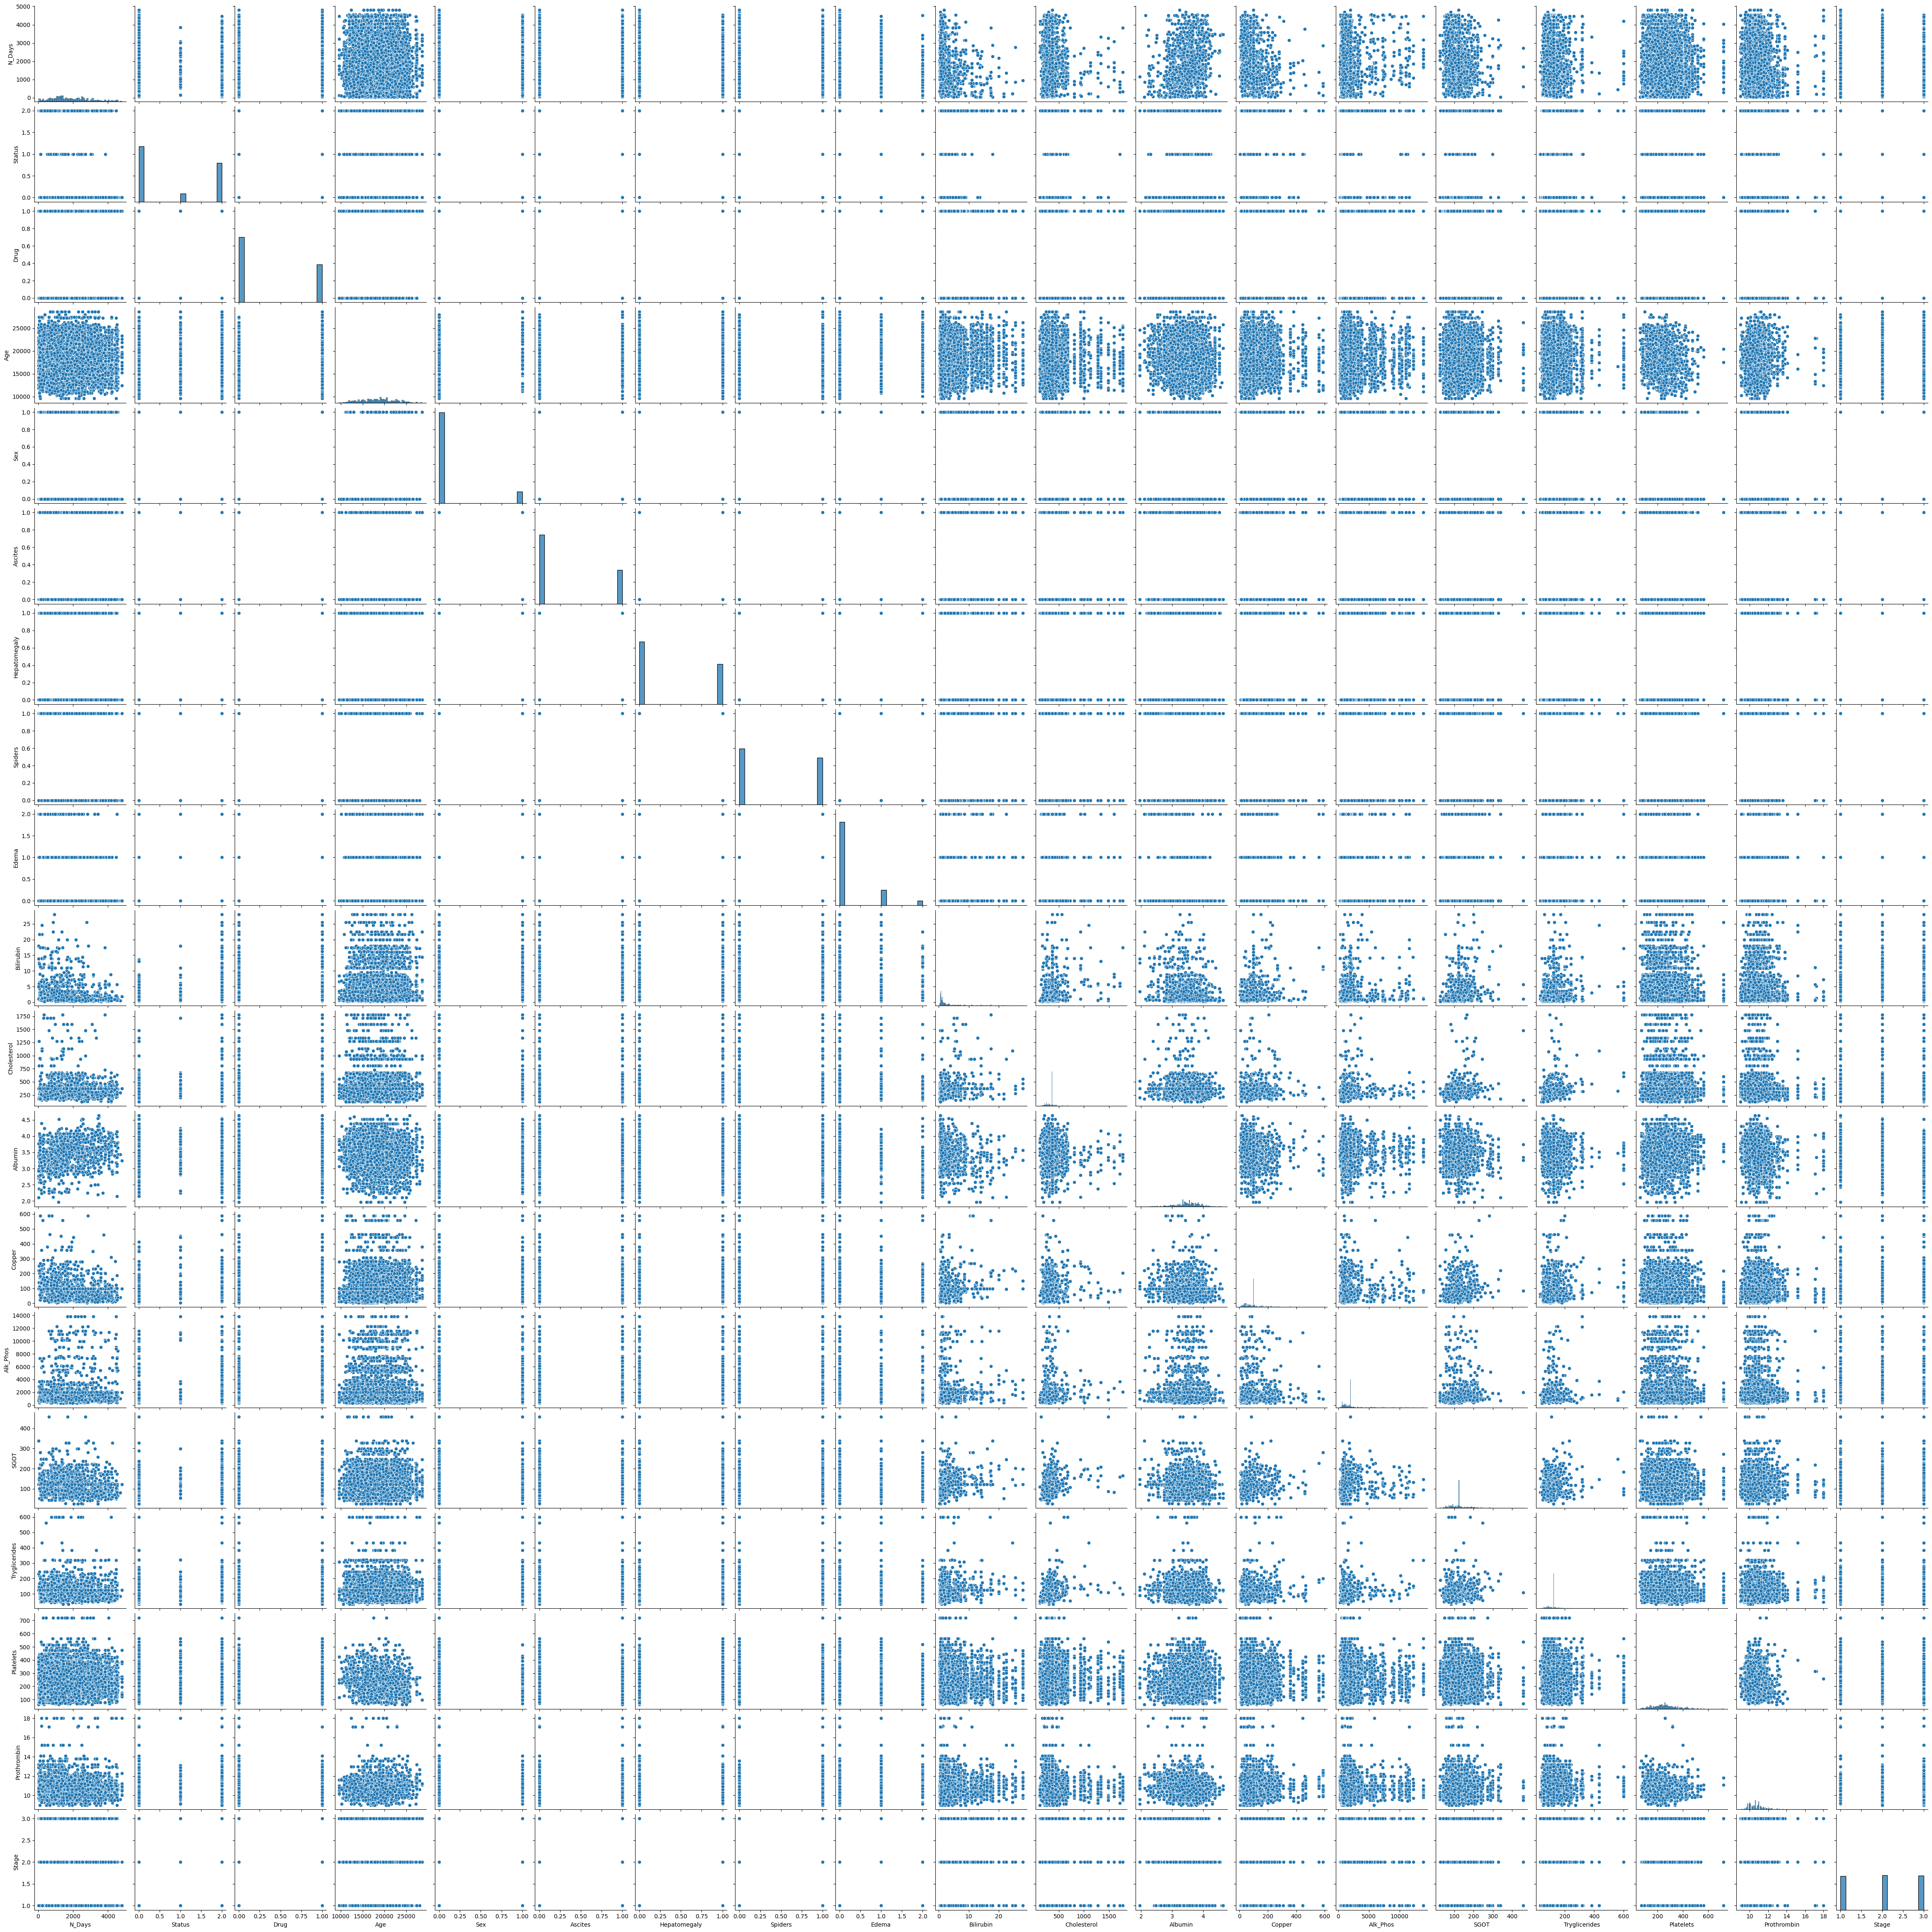

In [20]:
pairplots = sns.pairplot(df)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

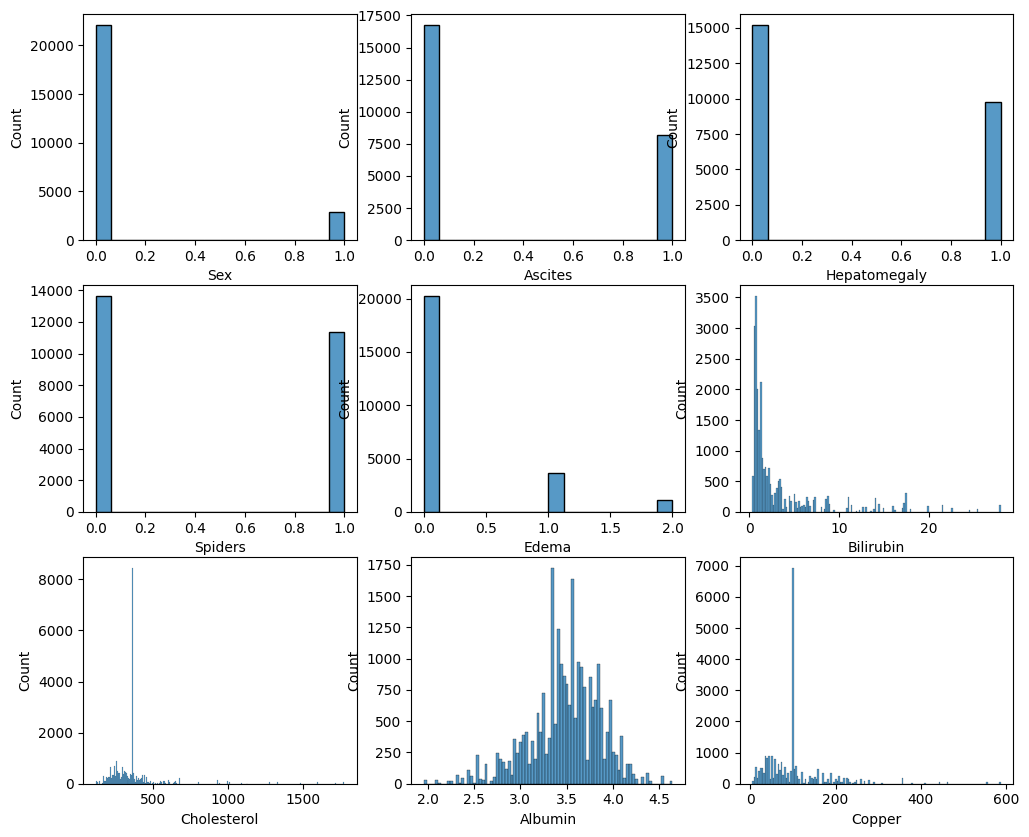

In [21]:
categorial_cols = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper']

plt.figure(figsize = (12,10))
for i, series in enumerate(categorial_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[series])

In [22]:
df.describe(percentiles=[.25, .50, .75]).T

count          mean          std      min       25%  \
N_Days         25000.0   1887.117040  1091.690918    41.00   1080.00   
Status         25000.0      0.837600     0.944744     0.00      0.00   
Drug           25000.0      0.366920     0.481974     0.00      0.00   
Age            25000.0  18495.877080  3737.596616  9598.00  15694.00   
Sex            25000.0      0.114520     0.318448     0.00      0.00   
Ascites        25000.0      0.328080     0.469524     0.00      0.00   
Hepatomegaly   25000.0      0.390280     0.487823     0.00      0.00   
Spiders        25000.0      0.455440     0.498020     0.00      0.00   
Edema          25000.0      0.234480     0.515820     0.00      0.00   
Bilirubin      25000.0      3.402644     4.707491     0.30      0.80   
Cholesterol    25000.0    372.331471   193.668452   120.00    275.00   
Albumin        25000.0      3.486578     0.380488     1.96      3.29   
Copper         25000.0    100.184663    73.184840     4.00     52.00   
Alk_Phos       25000.0   1995.675597  1798.885660   289.00   1032.00   
SGOT           25000.0    123.166345    47.747616    26.35     92.00   
Tryglicerides  25000.0    123.822548    52.786350    33.00     92.00   
Platelets      25000.0    256.007337    98.679006    62.00    189.00   
Prothrombin    25000.0     10.734549     0.904436     9.00     10.00   
Stage          25000.0      2.001160     0.813870     1.00      1.00   

                        50%           75%       max  
N_Days          1680.000000   2576.000000   4795.00  
Status             0.000000      2.000000      2.00  
Drug               0.000000      1.000000      1.00  
Age            18499.000000  20955.000000  28650.00  
Sex                0.000000      0.000000      1.00  
Ascites            0.000000      1.000000      1.00  
Hepatomegaly       0.000000      1.000000      1.00  
Spiders            0.000000      1.000000      1.00  
Edema              0.000000      0.000000      2.00  
Bilirubin          1.300000      3.400000     28.00  
Cholesterol      369.510563    369.510563   1775.00  
Albumin            3.510000      3.750000      4.64  
Copper            97.648387    107.000000    588.00  
Alk_Phos        1828.000000   1982.655769  13862.40  
SGOT             122.556346    134.850000    457.25  
Tryglicerides    124.702128    127.000000    598.00  
Platelets        251.000000    311.000000    721.00  
Prothrombin       10.600000     11.100000     18.00  
Stage              2.000000      3.000000      3.00

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Stage
1    8265
2    8441
3    8294
Name: Age, dtype: int64


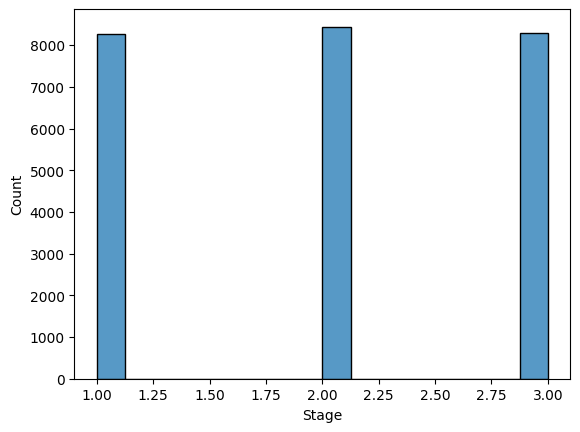

In [23]:
sns.histplot(df['Stage'])
print(df.groupby(['Stage'])['Age'].count())

In [24]:
X = df.drop('Stage', axis = 1)
y = df['Stage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

<h2>k-NN</h2>

In [25]:
kNN = KNeighborsClassifier()

params_kNN = {'n_neighbors': range(1, 15), 'weights': ['uniform', 'distance']}
search_kNN = GridSearchCV(kNN, params_kNN, cv = 5)
search_kNN.fit(X_train, y_train)

print('Best params: ', search_kNN.best_params_)
print('-'*100)
print('Best score: ', search_kNN.best_score_)

Best params:  {'n_neighbors': 6, 'weights': 'distance'}
----------------------------------------------------------------------------------------------------
Best score:  0.8654933333333334


In [26]:
kNN_best = search_kNN.best_estimator_
predictions = kNN_best.predict(X_test)
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           1       0.87      0.86      0.87      2093
           2       0.86      0.86      0.86      2151
           3       0.87      0.87      0.87      2006

    accuracy                           0.86      6250
   macro avg       0.86      0.87      0.86      6250
weighted avg       0.86      0.86      0.86      6250



<h2>Decision Tree</h2>

In [29]:
tree = DecisionTreeClassifier()
params_tree_random = {'criterion': ['gini', 'entropy',], 'max_depth': range(1,21), 'min_samples_split': range(1, 100, 5),\
                   'min_samples_leaf': range(5, 100, 5)}
random_search_tree = RandomizedSearchCV(tree, params_tree_random, cv = 5)
random_search_tree.fit(X_train, y_train)

print('Best params: ', random_search_tree.best_params_)
print('-'*100)
print('Best score: ', random_search_tree.best_score_)

Best params:  {'min_samples_split': 46, 'min_samples_leaf': 10, 'max_depth': 15, 'criterion': 'gini'}
----------------------------------------------------------------------------------------------------
Best score:  0.8570666666666668


In [30]:
tree_best = random_search_tree.best_estimator_
predictions = tree_best.predict(X_test)
print(classification_report(predictions, y_test))
print('-'*100)
print(confusion_matrix(predictions, y_test))

              precision    recall  f1-score   support

           1       0.86      0.87      0.87      2056
           2       0.86      0.82      0.84      2275
           3       0.86      0.90      0.88      1919

    accuracy                           0.86      6250
   macro avg       0.86      0.87      0.86      6250
weighted avg       0.86      0.86      0.86      6250

----------------------------------------------------------------------------------------------------
[[1796  180   80]
 [ 218 1860  197]
 [  70  114 1735]]


In [33]:
params_tree = {'criterion': ['entropy', 'gini'], 'max_depth': range(14,22), 'min_samples_split': range(30, 62),\
                   'min_samples_leaf': range(0, 20)}

search_tree = GridSearchCV(tree, params_tree, cv = 5)
search_tree.fit(X_train, y_train)

print('Best params: ', search_tree.best_params_)
print('-'*100)
print('Best score: ', search_tree.best_score_)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2560 fits failed out of a total of 51200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2560 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _

Best params:  {'criterion': 'entropy', 'max_depth': 21, 'min_samples_leaf': 1, 'min_samples_split': 30}
----------------------------------------------------------------------------------------------------
Best score:  0.8895466666666666


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.84906667 0.84826667 0.84805333]
  warnings.warn(


In [34]:
tree_best = search_tree.best_estimator_
predictions = tree_best.predict(X_test)
print(classification_report(predictions, y_test))
print('-'*100)
print(confusion_matrix(predictions, y_test))

              precision    recall  f1-score   support

           1       0.91      0.89      0.90      2132
           2       0.87      0.89      0.88      2105
           3       0.92      0.92      0.92      2013

    accuracy                           0.90      6250
   macro avg       0.90      0.90      0.90      6250
weighted avg       0.90      0.90      0.90      6250

----------------------------------------------------------------------------------------------------
[[1900  177   55]
 [ 134 1868  103]
 [  50  109 1854]]


<h2>Random Forest</h2>

In [35]:
forest = RandomForestClassifier()

params_forest_random = {'n_estimators': range(10, 200, 10), 'criterion': ['gini', 'entropy'], 'max_depth': range(1, 21),\
                     'min_samples_split': range(1, 100, 5),'min_samples_leaf': range(5, 100, 5)}

random_search_forest = RandomizedSearchCV(forest, params_forest_random, cv = 5)
random_search_forest.fit(X_train, y_train)

print('Best params: ', random_search_forest.best_params_)
print('-'*100)
print('Best score: ', random_search_forest.best_score_)

Best params:  {'n_estimators': 80, 'min_samples_split': 21, 'min_samples_leaf': 20, 'max_depth': 17, 'criterion': 'gini'}
----------------------------------------------------------------------------------------------------
Best score:  0.9114666666666666


In [36]:
forest_best = random_search_forest.best_estimator_
predictions = forest_best.predict(X_test)
print(classification_report(predictions, y_test))
print('-'*100)
print(confusion_matrix(predictions, y_test))

              precision    recall  f1-score   support

           1       0.91      0.93      0.92      2027
           2       0.91      0.90      0.90      2165
           3       0.94      0.92      0.93      2058

    accuracy                           0.92      6250
   macro avg       0.92      0.92      0.92      6250
weighted avg       0.92      0.92      0.92      6250

----------------------------------------------------------------------------------------------------
[[1887   97   43]
 [ 142 1951   72]
 [  55  106 1897]]
